As of the time that I'm writing this, there do not seem to exist any good, extant, general purpose Python tools for reading the Planetary Data System's bespoke ".IMG" format. I suspect that this is creating a serious barrier to entry to people trying to do planetary science in Python. What follows is an example of how to parse this kind of data into a numpy array. There are likely to be all kinds of special cases in the PDS archives, including malformed data, so this isn't a general solution. But it should get most users over a significant hump.

In [1]:
import struct
import numpy as np
import matplotlib.pyplot as plt

#### This is data from a Mastcam observation that I pulled semi-randomly from the archive. You need both the .IMG (image) file and the detached metadata .LBL (label) file. Some PDS3 .IMG files have _attached_ labels, and I explain how to deal with that below.

In [2]:
imgfile = 'test/data/msl/mastcam/1173MR0053120040602271E01_DRCL.IMG'
lblfile = 'test/data/msl/mastcam/1173MR0053120040602271E01_DRCL.LBL'

#### If you have installed the extraordinarily useful [`pvl` library](https://github.com/planetarypy/pvl), which is part of the nascent [`planetarypy` project](https://github.com/planetarypy), then you can use it to load the LBL file into a nice dictionary structure, as in the commented out section below. To avoid the extra dependency for this example, I've just manually defined the values. If you also wanted to avoid the dependency, you could use to your favorite text viewer to open the LBL file and find the values of interest, or you could write a simple text parser to just grab the values you want and throw away the rest. If the metadata are included in the file as a prepended header, then you can still just open up the file with your favorite text viewer and pull the numbers out, because the header portion of the file will be in plain old ASCII.

In [3]:
#import pvl
#lbl = pvl.load(lblfile)
#LINES = lbl['IMAGE']['LINES']
#LINE_SAMPLES = lbl['IMAGE']['LINE_SAMPLES']
#SAMPLE_BITS = lbl['IMAGE']['SAMPLE_BITS']
#BYTES_PER_PIXEL = int(SAMPLE_BITS/8)
#BANDS = lbl['IMAGE']['BANDS']
#pixels = LINES*LINE_SAMPLES*BANDS # total pixels in the RGB image "cube"

In [4]:
LINES = 1196 # i.e. rows
LINE_SAMPLES = 1339 # i.e. columns
SAMPLE_BITS = 8 # The bits assigned to each image pixel, e.g. as in an 8-bit video game
BYTES_PER_PIXEL = int(SAMPLE_BITS/8) # Convert bits to bytes.
BANDS = 3 # The three elements of the bayer filter.
pixels = LINES*LINE_SAMPLES*BANDS # total pixels in the RGB image "cube"

#### There are a lot of options for the format (fmt) string below, that will depend on things defined in the header. This is about the simplest possible case and, mercifully, also correct for the file that I happened to grab for testing...

In [5]:
pixels = LINES*LINE_SAMPLES*BANDS # total pixels in the RGB image "cube"
fmt = '{endian}{pixels}{fmt}'.format(endian='<',pixels=pixels,fmt='B')

#### The following opens up the file and then reads out the number of bytes in the cube (which in this case is the same as the number of pixels), and then reshapes the array into 3 x n x m.

#### If the label were prepended to the IMG file (as is done with MER Pancam data, for example), or if you wanted to skip a band, then the commented out `seek()` method would be used to skip the number of bytes necessary to get to where your data of interest starts. This value would be defined in some kind of label value (or combination of label values).

In [6]:
with open(imgfile,'rb') as f:
    #f.seek(LABEL_BYTES) # Skip over the prepended header data.
    img = np.array(struct.unpack(
        fmt,f.read(pixels*BYTES_PER_PIXEL))).reshape(3,LINES,LINE_SAMPLES)
print(np.shape(img))

(3, 1196, 1339)


#### `plt.imshow()` wants an array of n x m x 3, so we have to restructure it for display.

In [7]:
rgb = np.stack([img[0,:,:],img[1,:,:],img[2,:,:]],axis=2)
print(np.shape(rgb))

(1196, 1339, 3)


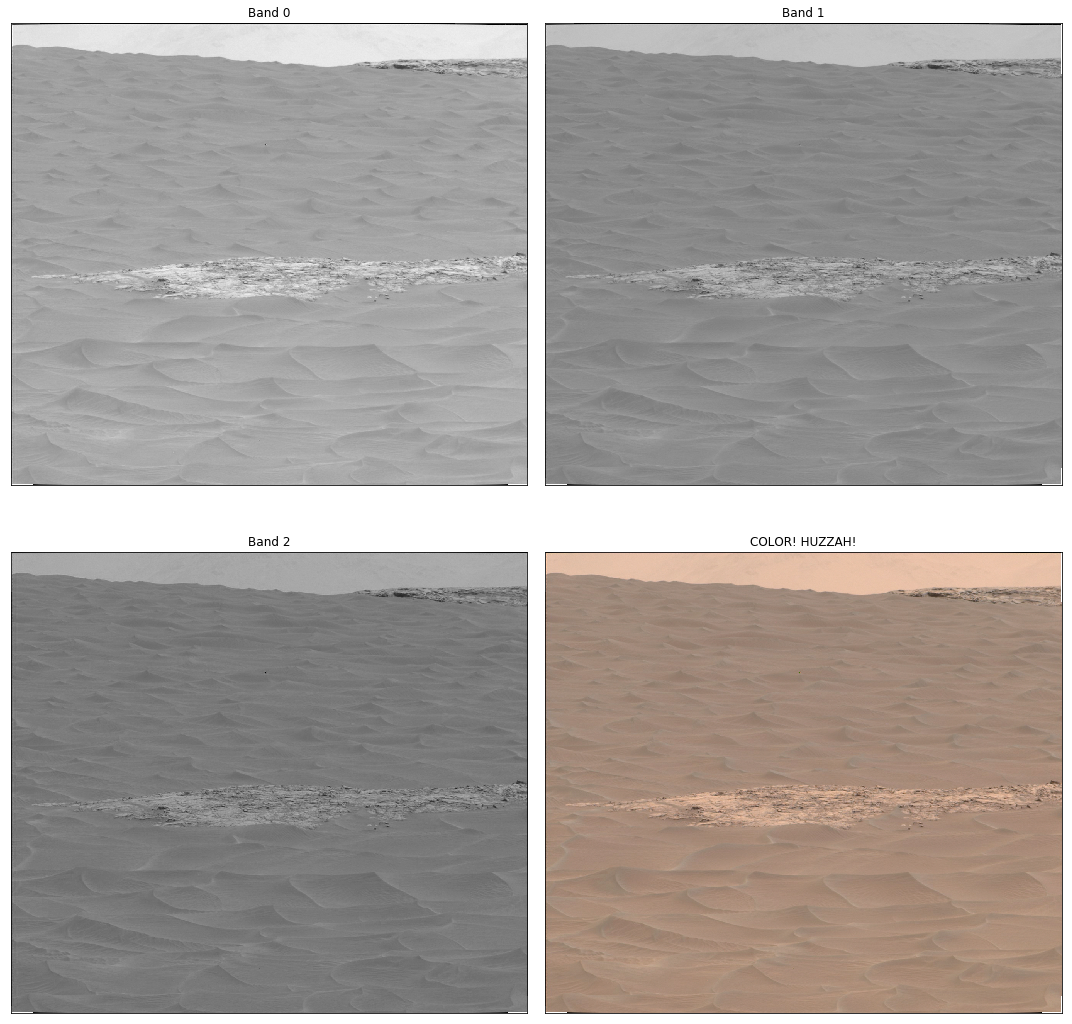

In [8]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.title('Band 0')
plt.imshow(img[0,:,:],cmap='gray')
plt.xticks([])
plt.yticks([])
plt.subplot(2,2,2)
plt.title('Band 1')
plt.imshow(img[1,:,:],cmap='gray')
plt.xticks([])
plt.yticks([])
plt.subplot(2,2,3)
plt.title('Band 2')
plt.imshow(img[2,:,:],cmap='gray')
plt.xticks([])
plt.yticks([])
plt.subplot(2,2,4)
plt.title('COLOR! HUZZAH!')
plt.imshow(rgb)
plt.xticks([])
plt.yticks([])
plt.tight_layout()

### Now you have a superpower.


#### A bunch of file formats that claim to be different are exactly the kind of file that we just opened, so now you have a good chance of being able to open all of those as well. These file types are common in scientific research, possibly because it's an almost perfectly self-describing way to format array data, so it makes for a good archival format. (I don't know why so many people thought that they needed to make their own variant, though.) For example, the Flexible Image Transport System (FITS) format that is ubiquitous in astronomy uses exactly these same basic ideas. Or if you are intersted in video framerate "lucky" imaging of planets, that community uses a format called "SER" that is also the same kind of thing.

#### For reference, here are some functions I wrote to parse SER data. This gives an idea of how the `fmt` parameter might change in different situations, and how to cope with a prepended file header. It also includes the capability to pick out a specific frame of data (which would be equivalent to a "band" in the Mastcam example).

In [9]:
# Scripts for reading SER data files.

def readheader(filename,verbose=1):
    header = {}
    with open(filename,'rb') as f:
        header['FileID'] = f.read(14) #str
        header['LuID'] = struct.unpack('<I',f.read(4))[0] #int32
        header['ColorID'] = struct.unpack('<I',f.read(4))[0] #int32
        header['LittleEndian'] = struct.unpack('<I',f.read(4))[0] #int32
        header['ImageWidth'] = struct.unpack('<I',f.read(4))[0] #int32
        header['ImageHeight'] = struct.unpack('<I',f.read(4))[0] #int32
        header['PixelDepth'] = struct.unpack('<I',f.read(4))[0] #int32
        header['BytePerPixel'] = 1 if header['PixelDepth']<=8 else 2
        header['FrameCount'] = struct.unpack('<I',f.read(4))[0] #int32
        header['Observer'] = struct.unpack('<40s',f.read(40))[0] #str
        header['Instrument'] = struct.unpack('<40s',f.read(40))[0] #str
        header['Telescope'] = struct.unpack('<40s',f.read(40))[0] #str
        header['DateTime'] = struct.unpack('<8s',f.read(8))[0] #"Date"
        header['DateTime_UTC'] = struct.unpack('<8s',f.read(8))[0] #"Date"
    if verbose:
        print('{f} - {d}'.format(f=filename,d=header['DateTime']))
        print('    Dims: {h}x{w}'.format(
                                w=header['ImageWidth'],h=header['ImageHeight']))
        print('    Frames: {n}'.format(n=header['FrameCount']))
    return header

def readframe(filename,frame,header=False,verbose=1):
    if not header:
        header = readheader(filename,verbose=verbose)
    if frame > header['FrameCount']-1:
        print('ERROR: Frame #{frame} requested of {count} available.'.format(
                                                frame=frame, count=FrameCount))
        return False
    HeaderBytes = 178 # Standardized header length
    ImagePixels = header['ImageWidth']*header['ImageHeight']
    ImageBytes = ImagePixels*header['BytePerPixel']
    with open(filename,'rb') as f:
        f.seek(HeaderBytes+ImageBytes*frame) # Skip the header and some number of frames
        fmt = '{endian}{pixels}{fmt}'.format(
                            endian='>' if header['LittleEndian'] else '<',
                            pixels=ImagePixels,
                            fmt='H' if header['BytePerPixel']==2 else 'B')
        img = np.array(struct.unpack(fmt,f.read(ImageBytes))).reshape(
                                    header['ImageHeight'],header['ImageWidth'])

        return img

If you figure out how to handle any special cases or other IMG or PDS data, please consider adding example code to this repo with a pull request.